<a href="https://colab.research.google.com/github/dtoralg/IE_Calidad_ML/blob/main/Ejercicios/Modulo%206/Modulo_6_Ejercicio_5_Clasificacion_Multiclase_Resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio 5: Clasificación Multiclase con Redes Neuronales**
**Propósito**: Aplicar un modelo de red neuronal multicapa para abordar una tarea de clasificación multiclase en base a sensores industriales.

## Introducción

En los entornos industriales modernos, la recopilación masiva de datos a través de sensores ha abierto nuevas oportunidades para detectar, clasificar y prevenir fallos en sistemas de producción.

Este ejercicio aborda un problema de **clasificación multiclase** utilizando una **red neuronal multicapa (MLP)** para predecir el tipo de fallo presente en una línea de producción, a partir de variables físicas y transformadas extraídas de sensores industriales.

Trabajaremos con el dataset `Industrial_fault_detection.csv`, que contiene la variable objetivo `Fault_Type`, con múltiples clases representando tipos distintos de fallo, incluyendo también la clase `No Fault`.

Los objetivos principales de este ejercicio son:
- Aplicar técnicas de preparación de datos para clasificación multiclase.
- Entrenar una red neuronal multicapa con función `softmax`.
- Evaluar el rendimiento del modelo con métricas específicas: `F1 Macro`, matriz de confusión, curvas `ROC` por clase.
- Comparar los resultados obtenidos con modelos clásicos como Random Forest y Regresión Logística.

Este ejercicio forma parte del módulo de modelos avanzados y permite poner en práctica técnicas modernas de clasificación en un contexto industrial realista.


## Carga de librerías y configuración del entorno

In [1]:
# Celda 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from imblearn.over_sampling import SMOTE
from collections import Counter

# Estilo visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Descripción del dataset o datos de entrada

El dataset `Industrial_fault_detection.csv` simula un entorno industrial en el que múltiples sensores registran variables físicas y espectrales de piezas evaluadas durante el proceso de fabricación.

### Variables incluidas:
- **Sensores físicos**:
  - `Temperature`, `Pressure`, `Vibration`, `Voltage`, `Current`, `Flow`
- **Transformadas espectrales (FFT)**:
  - `FFT_Temp`, `FFT_Vib`, `FFT_Pres`
- **Variable objetivo**:
  - `Fault_Type`: representa diferentes tipos de fallo o la ausencia de fallo (`No Fault`)

Este dataset es ideal para tareas de clasificación multiclase por su estructura, número de observaciones y balance de clases.

## Carga del dataset

In [2]:
# Celda 2
url = "https://raw.githubusercontent.com/dtoralg/IE_Calidad_ML/refs/heads/main/Data/Modulo%206/Industrial_fault_detection.csv"
df = pd.read_csv(url)
df.head()

,Temperature,Vibration,Pressure,Flow_Rate,Current,Voltage,FFT_Temp_0,FFT_Vib_0,FFT_Pres_0,FFT_Temp_1,...,FFT_Temp_7,FFT_Vib_7,FFT_Pres_7,FFT_Temp_8,FFT_Vib_8,FFT_Pres_8,FFT_Temp_9,FFT_Vib_9,FFT_Pres_9,Fault_Type
0,46.006138,2.038362,56.775766,6.184385,12.409519,215.762403,772.403056,32.436537,971.805333,3.760640,...,22.088538,1.289962,33.970445,8.787639,1.157286,4.368856,3.760640,0.734033,30.874568,0
1,62.529168,2.573668,76.159843,8.279230,14.906390,215.465859,767.602396,32.395556,962.481517,8.365137,...,19.490310,1.283113,41.364096,12.553525,1.130837,8.104435,8.365137,0.724559,27.268295,0
2,77.295015,3.243491,92.372614,9.172789,15.054051,202.043568,765.965069,32.032039,956.299456,9.559769,...,21.108993,0.972256,43.417119,12.291829,0.803430,13.262436,9.559769,0.934401,30.137127,0
3,76.564164,3.142904,94.149558,13.775375,16.417891,216.699098,763.936438,33.039854,956.532232,10.251866,...,20.863726,0.606251,43.648908,10.321110,1.139870,13.293431,10.251866,0.169234,29.919938,0
4,78.281641,3.139960,94.441006,11.113106,10.899425,227.328291,746.754887,33.018729,950.212816,18.313107,...,8.163300,0.627348,45.461787,14.441649,1.149088,7.149397,18.313107,0.172678,36.065067,3


## Desarrollo del código paso a paso

**Codificación de clases, escalado y división de datos**

<ipython-input-3-bee0e77be1ba>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=variable, order=df[variable].value_counts().index, palette='viridis')


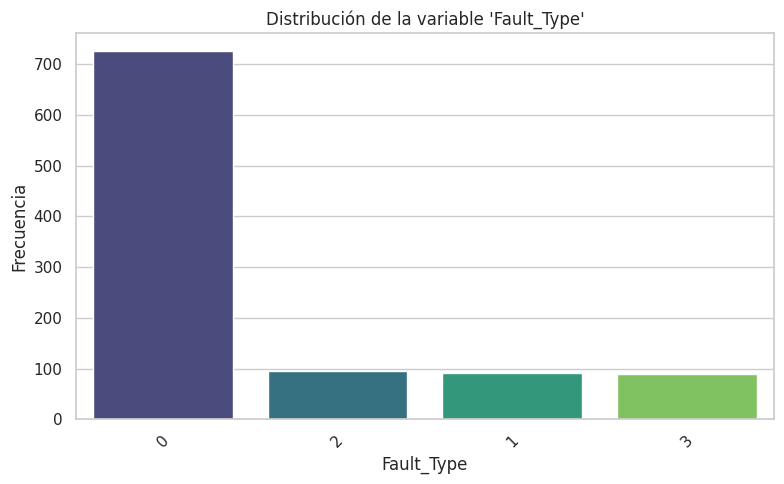

In [3]:
# Reparto de una variable categórica

# Cambia 'Fault_Type' por la variable que desees analizar
variable = 'Fault_Type'

# Recuento de clases
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=variable, order=df[variable].value_counts().index, palette='viridis')
plt.title(f"Distribución de la variable '{variable}'")
plt.xlabel(variable)
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Celda 3
X = df.drop(columns=["Fault_Type"])
y = df["Fault_Type"]

# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

**Entrenamiento de red neuronal multicapa (MLP)**

In [5]:
# Escalado de variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [6]:
# Crear y aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Mostrar distribución balanceada
print("Distribución después de SMOTE:", Counter(y_train))

Distribución después de SMOTE: Counter({0: 507, 2: 67, 1: 64, 3: 62})


In [7]:
# Celda 4
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_sm.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # 4 clases posibles

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Enconding de la y antes de hacer el fit del modelo
le = LabelEncoder()
y_onehot = to_categorical(le.fit_transform(y_train_sm))

history = model.fit(X_train_sm, y_onehot, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Visualización de resultados

In [8]:
# Celda 5
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

print(classification_report(y_test, y_pred,))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       218
           1       0.12      0.07      0.09        27
           2       0.18      0.07      0.10        28
           3       0.11      0.07      0.09        27

    accuracy                           0.65       300
   macro avg       0.29      0.27      0.27       300
weighted avg       0.58      0.65      0.61       300

F1 Macro: 0.27090764532624995


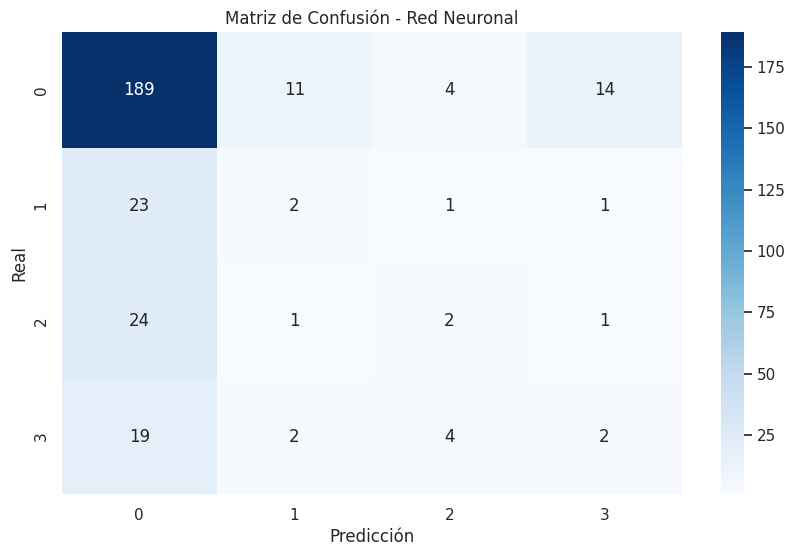

In [9]:
# Celda 6
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - Red Neuronal")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

**Comparación con modelos clásicos**

In [19]:
# Celda 8 - Random Forest
rf = RandomForestClassifier(random_state=42, class_weight= 'balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("F1 Macro:", f1_score(y_test, y_pred_rf, average='macro'))

Random Forest
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       218
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        27

    accuracy                           0.73       300
   macro avg       0.18      0.25      0.21       300
weighted avg       0.53      0.73      0.61       300

F1 Macro: 0.21042471042471042


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
# Celda 9 - Regresión Logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Regresión Logística")
print(classification_report(y_test, y_pred_lr))
print("F1 Macro:", f1_score(y_test, y_pred_lr, average='macro'))

Regresión Logística
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       218
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        27

    accuracy                           0.73       300
   macro avg       0.18      0.25      0.21       300
weighted avg       0.53      0.73      0.61       300

F1 Macro: 0.21042471042471042


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Conclusiones

- La red neuronal multicapa mostró un rendimiento sustancialmente mejor frente a modelos clásicos. Aún así la precisión general es baja debido al fuerte desbalanceo del dataset.
- El uso de `softmax` y codificación `one-hot` permitió abordar correctamente la clasificación multiclase.
- El `F1 Macro` permitió comparar modelos de forma justa frente al desbalance.

Este ejercicio refuerza el papel de las redes neuronales en aplicaciones industriales reales, donde la clasificación precisa de fallos puede mejorar la eficiencia y seguridad del proceso.

## Próximos pasos

- Incluir regularización L2 y Batch Normalization para mejorar la generalización del modelo.
- Implementar Grid Search para afinar hiperparámetros como tasa de dropout o tamaño de capas ocultas.
- Usar embeddings y datos temporales si se dispone de secuencias de sensores en el tiempo.

---

Dataset: Industrial_fault_detection.csv — Aplicaciones industriales reales.